<a href="https://colab.research.google.com/github/j-o-s-h-0/ML-Life-Expectancy-Predictions/blob/main/Life_Expectancy_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data handling libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ML model libraries
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Performance evaluation libraries
from sklearn import metrics

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


# Pre-processing

## Life Expectancy Data

In [3]:
# Get life expectancy by county data
nchs_le = pd.read_csv('/content/drive/MyDrive/Life Expectancy Predictions/NCHS_state_LE.csv')

In [4]:
# Remove rows that don't have life expectancy and county name
nchs_le = nchs_le[~nchs_le['Life Expectancy'].isna()]
nchs_le = nchs_le[~nchs_le['County'].isna()]
nchs_le = nchs_le[~(nchs_le['County']=='(blank)')]
nchs_le = nchs_le.reset_index(drop=True)

In [5]:
nchs_le.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error
0,Alabama,"Autauga County, AL",201.0,73.1,56.9-75.1,2.2348
1,Alabama,"Autauga County, AL",202.0,76.9,75.2-77.5,3.3453
2,Alabama,"Autauga County, AL",204.0,75.4,75.2-77.5,1.0216
3,Alabama,"Autauga County, AL",205.0,79.4,77.6-79.5,1.1768
4,Alabama,"Autauga County, AL",206.0,73.1,56.9-75.1,1.5519


In [6]:
nchs_le.shape

(67148, 6)

In [7]:
# Combine census tract regions into single row per county
def average(list):
  '''Return the average of list.'''
  return sum(list)/len(list)

def avg_county(df, column):
  '''Combine census tract regions in df into single row per county while averaging column.'''
  name = ''
  avgList = []
  main = 0
  mask = []
  # Iterate through rows in df
  for i, x in enumerate(df['County'].copy()):
    # Check if county name is the same as previous row
    if x == name:
      mask.append(False)
      avgList.append(df.loc[i, column])
    else:
      mask.append(True)
      if name:
        # Add average of county to main row
        df.loc[main, column] = average(avgList)
      name = x
      main = i
      avgList = []
      avgList.append(df.loc[i, column])
  df.loc[main, column] = average(avgList)

  df = df[mask]
  df = df.reset_index(drop=True)

  return df


nchs_le = avg_county(nchs_le, 'Life Expectancy')
nchs_le.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error
0,Alabama,"Autauga County, AL",201.00,75.320000,56.9-75.1,2.2348
1,Alabama,"Baldwin County, AL",101.00,77.482759,75.2-77.5,1.0694
2,Alabama,"Barbour County, AL",9501.00,73.971429,75.2-77.5,1.4584
3,Alabama,"Bibb County, AL",100.01,73.550000,56.9-75.1,2.0776
4,Alabama,"Blount County, AL",501.01,76.077778,75.2-77.5,1.7379


In [8]:
# Remove state abreviation in county column
for i, x in enumerate(nchs_le['County'].copy()):
  nchs_le.at[i, 'County'] = x[:-4]

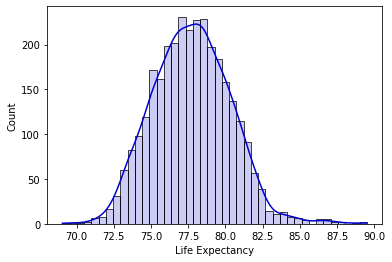

In [9]:
# Distribution of output variable
sns.histplot(nchs_le['Life Expectancy'], kde=True, color='mediumblue', alpha=0.2)

## Race Data

In [10]:
# Get population of each race by county data
census_race = pd.read_csv('/content/drive/MyDrive/Life Expectancy Predictions/county_race.csv',
                          encoding='latin-1')

In [11]:
# Drop unneded column
census_race = census_race.drop("Unnamed: 0", axis=1)
census_race.head()

,STATE,COUNTY,FIPS,WAC,BA,IA,AA,NA
0,Alabama,Autauga County,1001,44080.066933,9653.512997,251.205553,469.857250,47.357267
1,Alabama,Baldwin County,1003,161276.742069,17933.876408,1357.189316,1430.908814,132.283393
2,Alabama,Barbour County,1005,13994.261946,13071.385122,168.195070,112.922296,48.235566
3,Alabama,Bibb County,1007,17715.411025,5044.585596,67.168901,22.092093,33.742385
4,Alabama,Blount County,1009,55931.189066,827.034667,352.735170,125.259437,64.781659


In [12]:
census_race.shape

(3142, 8)

In [13]:
# Merge life expectancy and race data then drop redundant state and county columns
df = nchs_le.merge(census_race, left_on=['State', 'County'], right_on=['STATE', 'COUNTY'])
df = df.drop(columns=['STATE', 'COUNTY'])
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3109 entries, 0 to 3108
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   State                           3109 non-null   object 
 1   County                          3109 non-null   object 
 2   Census Tract Number             3109 non-null   float64
 3   Life Expectancy                 3109 non-null   float64
 4   Life Expectancy Range           3109 non-null   object 
 5   Life Expectancy Standard Error  3109 non-null   float64
 6   FIPS                            3109 non-null   int64  
 7   WAC                             3109 non-null   float64
 8   BA                              3109 non-null   float64
 9   IA                              3109 non-null   float64
 10  AA                              3109 non-null   float64
 11  NA                              3109 non-null   float64
dtypes: float64(8), int64(1), object(3)

In [14]:
# Calculate total population of each county and store it in a new column
df['Population'] = df['WAC'] + df['BA'] + df['IA'] + df['AA'] + df['NA']

In [15]:
# Calculate the percentage of each race in a county's population and store the results in a new column
for column in ['WAC','BA','IA','AA','NA']:
  df[column+'_pct'] = df[column] / df['Population']

In [16]:
df.describe()

,Census Tract Number,Life Expectancy,Life Expectancy Standard Error,FIPS,WAC,BA,IA,AA,NA,Population,WAC_pct,BA_pct,IA_pct,AA_pct,NA_pct
count,3109.000000,3109.000000,3109.000000,3109.000000,3.109000e+03,3.109000e+03,3109.000000,3.109000e+03,3109.000000,3.109000e+03,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000
mean,5400.913609,77.729052,1.767124,30402.833387,7.979427e+04,1.306352e+04,1199.330281,4.864259e+03,216.888310,9.913827e+04,0.873006,0.092277,0.021557,0.012172,0.000988
std,4417.445316,2.583978,0.641018,15171.637842,2.348617e+05,5.706289e+04,4929.380135,3.720679e+04,2106.274924,3.133698e+05,0.160670,0.147579,0.074130,0.025585,0.004449
min,1.000000,69.050000,0.458800,1001.000000,3.534373e+02,0.000000e+00,0.000000,0.000000e+00,0.000000,7.630000e+02,0.131838,0.000000,0.000000,0.000000,0.000000
25%,202.010000,75.933333,1.311400,18179.000000,9.813835e+03,9.160413e+01,54.088381,3.790497e+01,2.988100,1.152300e+04,0.830169,0.005466,0.002931,0.003143,0.000190
50%,8701.000000,77.700000,1.629200,29161.000000,2.316939e+04,7.965457e+02,160.048509,1.320307e+02,11.611447,2.615500e+04,0.943828,0.021762,0.005136,0.005244,0.000419
75%,9572.000000,79.500000,2.074300,45079.000000,6.033319e+04,5.757900e+03,587.108298,6.887421e+02,50.501554,6.745500e+04,0.979093,0.108711,0.011038,0.010795,0.000906
max,9796.000000,89.500000,3.988600,56045.000000,7.271160e+06,1.320861e+06,142952.571018,1.406235e+06,94786.921301,9.780717e+06,0.997023,0.859731,0.863864,0.465748,0.141518


In [17]:
# Remove counties with a population of less than 10,000
df = df[df['Population']>10000]

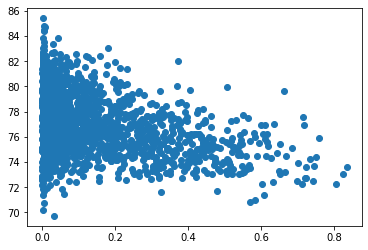

In [18]:
# Display the relationship between black or Aftrican American population percent with life expectancy
plt.scatter(df['BA_pct'], df['Life Expectancy'])

In [19]:
df.shape

(2446, 18)

## Obesity Data

In [20]:
# Get obesity by county data
nchs_obesity = pd.read_csv('/content/drive/MyDrive/Life Expectancy Predictions/obesity_prevalence_by_state.csv')

In [21]:
nchs_obesity.head()

,State,Prevalence,95% CI
0,Alabama,36.1,"(34.6, 37.7)"
1,Alaska,30.5,"(27.8, 33.4)"
2,Arizona,31.4,"(29.7, 33.2)"
3,Arkansas,37.4,"(35.5, 39.4)"
4,California,26.2,"(25.1, 27.2)"


In [22]:
nchs_obesity.shape

(53, 3)

In [23]:
# Remove rows that don't have obesity prevalence, make prevalence a value between 0 and 1, and drop unneded column
nchs_obesity = nchs_obesity[~nchs_obesity['Prevalence'].isna()]
nchs_obesity['Prevalence'] = nchs_obesity['Prevalence'] / 100
nchs_obesity = nchs_obesity.rename(columns={'Prevalence': 'obesity_prevalence'})
nchs_obesity = nchs_obesity.drop(columns=['95% CI'])

In [24]:
# Merge obesity prevalence with life expectancy and race data
df = df.merge(nchs_obesity, left_on=('State'), right_on=('State'))
df.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,FIPS,WAC,BA,IA,AA,NA,Population,WAC_pct,BA_pct,IA_pct,AA_pct,NA_pct,obesity_prevalence
0,Alabama,Autauga County,201.00,75.320000,56.9-75.1,2.2348,1001,44080.066933,9653.512997,251.205553,469.857250,47.357267,54502.0,0.808779,0.177122,0.004609,0.008621,0.000869,0.361
1,Alabama,Baldwin County,101.00,77.482759,75.2-77.5,1.0694,1003,161276.742069,17933.876408,1357.189316,1430.908814,132.283393,182131.0,0.885499,0.098467,0.007452,0.007856,0.000726,0.361
2,Alabama,Barbour County,9501.00,73.971429,75.2-77.5,1.4584,1005,13994.261946,13071.385122,168.195070,112.922296,48.235566,27395.0,0.510833,0.477145,0.006140,0.004122,0.001761,0.361
3,Alabama,Bibb County,100.01,73.550000,56.9-75.1,2.0776,1007,17715.411025,5044.585596,67.168901,22.092093,33.742385,22883.0,0.774173,0.220451,0.002935,0.000965,0.001475,0.361
4,Alabama,Blount County,501.01,76.077778,75.2-77.5,1.7379,1009,55931.189066,827.034667,352.735170,125.259437,64.781659,57301.0,0.976094,0.014433,0.006156,0.002186,0.001131,0.361


In [25]:
df.shape

(2425, 19)

## Health Insurance Data



In [26]:
# Get health insurance by county data
acs_hi = pd.read_csv('/content/drive/MyDrive/Life Expectancy Predictions/ACS_Health_Insurance.csv')

In [27]:
acs_hi.head()

,NAME,State,County,Percent,MoE
0,Census Tract 201,Hawaii,Hawaii County,4.4,1.859105
1,Census Tract 202.02,Hawaii,Hawaii County,2.7,3.532088
2,Census Tract 203,Hawaii,Hawaii County,5.2,2.658540
3,Census Tract 204,Hawaii,Hawaii County,1.9,2.096055
4,Census Tract 205,Hawaii,Hawaii County,7.0,3.559178


In [28]:
acs_hi.shape

(73642, 5)

In [29]:
# Remove rows that don't have health insurance percentage and county name and convert percent to value between 0 and 1
acs_hi = acs_hi[~acs_hi["Percent"].isna()]
acs_hi = acs_hi[~acs_hi["County"].isna()]
acs_hi["Percent"] = acs_hi["Percent"] / 100
acs_hi = acs_hi.reset_index(drop=True)

In [30]:
# Combine census tract regions into single row per county
acs_hi = avg_county(acs_hi, 'Percent')
acs_hi.head()

,NAME,State,County,Percent,MoE
0,Census Tract 201,Hawaii,Hawaii County,0.046667,1.859105
1,Census Tract 1.06,Hawaii,Honolulu County,0.032746,1.515324
2,Census Tract 319,Hawaii,Kalawao County,0.000000,36.065574
3,Census Tract 401.03,Hawaii,Kauai County,0.055154,2.005444
4,Census Tract 301,Hawaii,Maui County,0.051824,2.918466


In [31]:
# Rename column and drop unneeded columns
acs_hi = acs_hi.rename(columns={'Percent': 'h_insurance_pct'})
acs_hi = acs_hi.drop(columns=['MoE', 'NAME'])

In [32]:
# Merge health insurance with other data
df = df.merge(acs_hi, left_on=('State', 'County'), right_on=('State', 'County'))
df.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,FIPS,WAC,BA,IA,AA,NA,Population,WAC_pct,BA_pct,IA_pct,AA_pct,NA_pct,obesity_prevalence,h_insurance_pct
0,Alabama,Autauga County,201.0,75.320000,56.9-75.1,2.2348,1001,44080.066933,9653.512997,251.205553,469.857250,47.357267,54502.0,0.808779,0.177122,0.004609,0.008621,0.000869,0.361,0.076167
1,Alabama,Baldwin County,101.0,77.482759,75.2-77.5,1.0694,1003,161276.742069,17933.876408,1357.189316,1430.908814,132.283393,182131.0,0.885499,0.098467,0.007452,0.007856,0.000726,0.361,0.092765
2,Alabama,Baldwin County,101.0,77.482759,75.2-77.5,1.0694,1003,161276.742069,17933.876408,1357.189316,1430.908814,132.283393,182131.0,0.885499,0.098467,0.007452,0.007856,0.000726,0.361,0.085125
3,Alabama,Baldwin County,101.0,77.482759,75.2-77.5,1.0694,1003,161276.742069,17933.876408,1357.189316,1430.908814,132.283393,182131.0,0.885499,0.098467,0.007452,0.007856,0.000726,0.361,0.093667
4,Alabama,Barbour County,9501.0,73.971429,75.2-77.5,1.4584,1005,13994.261946,13071.385122,168.195070,112.922296,48.235566,27395.0,0.510833,0.477145,0.006140,0.004122,0.001761,0.361,0.114889


## Population Density Data

In [33]:
# Get population density by county data
pop_dense = pd.read_csv('/content/drive/MyDrive/Life Expectancy Predictions/Population_Density_By_County.csv')

In [34]:
pop_dense.head()

,GEO.id,GEO.id2,GEO.display-label,GCT_STUB.target-geo-id,GCT_STUB.target-geo-id2,GCT_STUB.display-label,Density per square mile of land area
0,0400000US01,1,Alabama,0500000US01001,1001,Autauga County,91.8
1,0400000US01,1,Alabama,0500000US01003,1003,Baldwin County,114.6
2,0400000US01,1,Alabama,0500000US01005,1005,Barbour County,31.0
3,0400000US01,1,Alabama,0500000US01007,1007,Bibb County,36.8
4,0400000US01,1,Alabama,0500000US01009,1009,Blount County,88.9


In [35]:
pop_dense.shape

(3221, 7)

In [36]:
# Rename columns and remove unneeded columns
pop_dense = pop_dense.rename(columns={'GEO.display-label':'State','GCT_STUB.display-label':'County','Density per square mile of land area':'Density'})
pop_dense = pop_dense[['State','County','Density']]

In [37]:
# Merge population density with other data
df = df.merge(pop_dense, left_on=('State','County'), right_on=('State','County'))
df.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,FIPS,WAC,BA,IA,...,NA,Population,WAC_pct,BA_pct,IA_pct,AA_pct,NA_pct,obesity_prevalence,h_insurance_pct,Density
0,Alabama,Autauga County,201.0,75.320000,56.9-75.1,2.2348,1001,44080.066933,9653.512997,251.205553,...,47.357267,54502.0,0.808779,0.177122,0.004609,0.008621,0.000869,0.361,0.076167,91.8
1,Alabama,Baldwin County,101.0,77.482759,75.2-77.5,1.0694,1003,161276.742069,17933.876408,1357.189316,...,132.283393,182131.0,0.885499,0.098467,0.007452,0.007856,0.000726,0.361,0.092765,114.6
2,Alabama,Baldwin County,101.0,77.482759,75.2-77.5,1.0694,1003,161276.742069,17933.876408,1357.189316,...,132.283393,182131.0,0.885499,0.098467,0.007452,0.007856,0.000726,0.361,0.085125,114.6
3,Alabama,Baldwin County,101.0,77.482759,75.2-77.5,1.0694,1003,161276.742069,17933.876408,1357.189316,...,132.283393,182131.0,0.885499,0.098467,0.007452,0.007856,0.000726,0.361,0.093667,114.6
4,Alabama,Barbour County,9501.0,73.971429,75.2-77.5,1.4584,1005,13994.261946,13071.385122,168.195070,...,48.235566,27395.0,0.510833,0.477145,0.006140,0.004122,0.001761,0.361,0.114889,31.0


In [38]:
df.shape

(2815, 21)

## Income Data

In [39]:
# Get income by county data
income = pd.read_csv('/content/drive/MyDrive/Life Expectancy Predictions/kaggle_income.csv', encoding='latin-1')

In [40]:
income.head()

,id,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean,Median,Stdev,sum_w
0,1011000,1,Alabama,AL,Mobile County,Chickasaw,Chickasaw city,City,place,36611,251,10894952,909156,30.771450,-88.079697,38773,30506,33101,1638.260513
1,1011010,1,Alabama,AL,Barbour County,Louisville,Clio city,City,place,36048,334,26070325,23254,31.708516,-85.611039,37725,19528,43789,258.017685
2,1011020,1,Alabama,AL,Shelby County,Columbiana,Columbiana city,City,place,35051,205,44835274,261034,33.191452,-86.615618,54606,31930,57348,926.031000
3,1011030,1,Alabama,AL,Mobile County,Satsuma,Creola city,City,place,36572,251,36878729,2374530,30.874343,-88.009442,63919,52814,47707,378.114619
4,1011040,1,Alabama,AL,Mobile County,Dauphin Island,Dauphin Island,Town,place,36528,251,16204185,413605152,30.250913,-88.171268,77948,67225,54270,282.320328


In [41]:
income.shape

(32526, 19)

In [42]:
# Remove unneeded columns
income = income[['State_Name','County','Mean']]

In [43]:
# Sort data by state and county and rename the state column
income = income.sort_values(by=['State_Name','County'])
income = income.rename(columns={'State_Name':'State'})
income = income.reset_index(drop=True)
income.head()

,State,County,Mean
0,Alabama,Autauga County,63066
1,Alabama,Autauga County,45862
2,Alabama,Autauga County,62222
3,Alabama,Autauga County,90262
4,Alabama,Autauga County,92018


In [44]:
# Combine census tract regions into single row per county
income = avg_county(income, 'Mean')
income.head()

,State,County,Mean
0,Alabama,Autauga County,53735.557235
1,Alabama,Barbour County,37725.000000
2,Alabama,Blount County,55127.000000
3,Alabama,Butler County,27993.000000
4,Alabama,Chambers County,45107.000000


In [45]:
# Merge income with other data
df = df.merge(income, left_on=('State','County'), right_on=('State','County'))
df.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,FIPS,WAC,BA,IA,...,Population,WAC_pct,BA_pct,IA_pct,AA_pct,NA_pct,obesity_prevalence,h_insurance_pct,Density,Mean
0,Alabama,Autauga County,201.00,75.320000,56.9-75.1,2.2348,1001,44080.066933,9653.512997,251.205553,...,54502.0,0.808779,0.177122,0.004609,0.008621,0.000869,0.361,0.076167,91.8,53735.557235
1,Alabama,Barbour County,9501.00,73.971429,75.2-77.5,1.4584,1005,13994.261946,13071.385122,168.195070,...,27395.0,0.510833,0.477145,0.006140,0.004122,0.001761,0.361,0.114889,31.0,37725.000000
2,Alabama,Blount County,501.01,76.077778,75.2-77.5,1.7379,1009,55931.189066,827.034667,352.735170,...,57301.0,0.976094,0.014433,0.006156,0.002186,0.001131,0.361,0.092833,88.9,55127.000000
3,Alabama,Blount County,501.01,76.077778,75.2-77.5,1.7379,1009,55931.189066,827.034667,352.735170,...,57301.0,0.976094,0.014433,0.006156,0.002186,0.001131,0.361,0.152667,88.9,55127.000000
4,Alabama,Butler County,9527.00,73.387500,56.9-75.1,1.8763,1013,11385.803902,9276.563397,63.496075,...,20928.0,0.544046,0.443261,0.003034,0.009255,0.000403,0.361,0.082556,27.0,27993.000000


## Really Cool Large Amount of Data

In [46]:
# Get education (among other features) by county data
ed = pd.read_csv('/content/drive/MyDrive/Life Expectancy Predictions/county_complete(edited).csv')

In [47]:
ed.head()

,state,name,female_2010,women_16_to_50_birth_rate_2017,hs_grad_2017,some_college_2017,bachelors_2017,mean_work_travel_2017,broadband_2017,computer_2017,homeownership_2010,persons_per_household_2017,metro_2013,fed_spending_2009,poverty_2017,poverty_age_under_5_2017,poverty_age_under_18_2017,unemployment_rate_2016,avg_family_size_2019
0,Alabama,Autauga County,51.3,7.4,87.7,29.1,25.0,25.8,76.6,86.2,77.5,2.59,1.0,331142.0,13.7,17.2,20.0,5.11,3.09
1,Alabama,Baldwin County,51.1,5.1,90.2,31.6,30.7,27.0,74.5,86.9,76.7,2.63,1.0,1119082.0,11.8,19.4,15.9,5.35,3.24
2,Alabama,Barbour County,46.9,7.2,73.1,25.5,12.0,23.4,57.2,73.4,68.0,2.54,0.0,240308.0,27.2,56.8,44.9,8.36,3.01
3,Alabama,Bibb County,46.3,7.6,82.1,25.0,13.2,30.0,62.0,74.8,82.9,2.97,1.0,163201.0,15.2,21.6,25.9,6.47,3.74
4,Alabama,Blount County,50.5,5.6,79.8,34.4,13.1,35.0,65.8,78.2,82.0,2.76,1.0,294114.0,15.6,29.5,25.3,5.40,3.33


In [48]:
# Merge with other data
df = df.merge(ed, left_on=('State','County'), right_on=('state','name'))
df.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,FIPS,WAC,BA,IA,...,computer_2017,homeownership_2010,persons_per_household_2017,metro_2013,fed_spending_2009,poverty_2017,poverty_age_under_5_2017,poverty_age_under_18_2017,unemployment_rate_2016,avg_family_size_2019
0,Alabama,Autauga County,201.00,75.320000,56.9-75.1,2.2348,1001,44080.066933,9653.512997,251.205553,...,86.2,77.5,2.59,1.0,331142.0,13.7,17.2,20.0,5.11,3.09
1,Alabama,Barbour County,9501.00,73.971429,75.2-77.5,1.4584,1005,13994.261946,13071.385122,168.195070,...,73.4,68.0,2.54,0.0,240308.0,27.2,56.8,44.9,8.36,3.01
2,Alabama,Blount County,501.01,76.077778,75.2-77.5,1.7379,1009,55931.189066,827.034667,352.735170,...,78.2,82.0,2.76,1.0,294114.0,15.6,29.5,25.3,5.40,3.33
3,Alabama,Blount County,501.01,76.077778,75.2-77.5,1.7379,1009,55931.189066,827.034667,352.735170,...,78.2,82.0,2.76,1.0,294114.0,15.6,29.5,25.3,5.40,3.33
4,Alabama,Butler County,9527.00,73.387500,56.9-75.1,1.8763,1013,11385.803902,9276.563397,63.496075,...,68.3,69.0,2.81,0.0,195055.0,24.4,30.1,34.8,6.93,3.78


In [49]:
# Change federal spending to federal spending per capita
df['fed_spending_2009'] = df['fed_spending_2009'] / df['Population']

In [50]:
# Drop redundant state and county columns and rename new columns
df = df.drop(columns=['state','name'])
df = df.rename(columns={'female_2010': 'female_pct', 'hs_grad_2017': 'hs_grad',
                        'bachelors_2017': 'bachelors',
                        'broadband_2017': 'broadband',
                        'unemployment_rate_2016': 'unemployment',
                        'poverty_age_under_18_2017': 'child_poverty',
                        'mean_work_travel_2017': 'mean_work_travel'})

In [51]:
df.shape

(1591, 39)

## More Preprocessing

In [52]:
df.shape

(1591, 39)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1591 entries, 0 to 1590
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   State                           1591 non-null   object 
 1   County                          1591 non-null   object 
 2   Census Tract Number             1591 non-null   float64
 3   Life Expectancy                 1591 non-null   float64
 4   Life Expectancy Range           1591 non-null   object 
 5   Life Expectancy Standard Error  1591 non-null   float64
 6   FIPS                            1591 non-null   int64  
 7   WAC                             1591 non-null   float64
 8   BA                              1591 non-null   float64
 9   IA                              1591 non-null   float64
 10  AA                              1591 non-null   float64
 11  NA                              1591 non-null   float64
 12  Population                      15

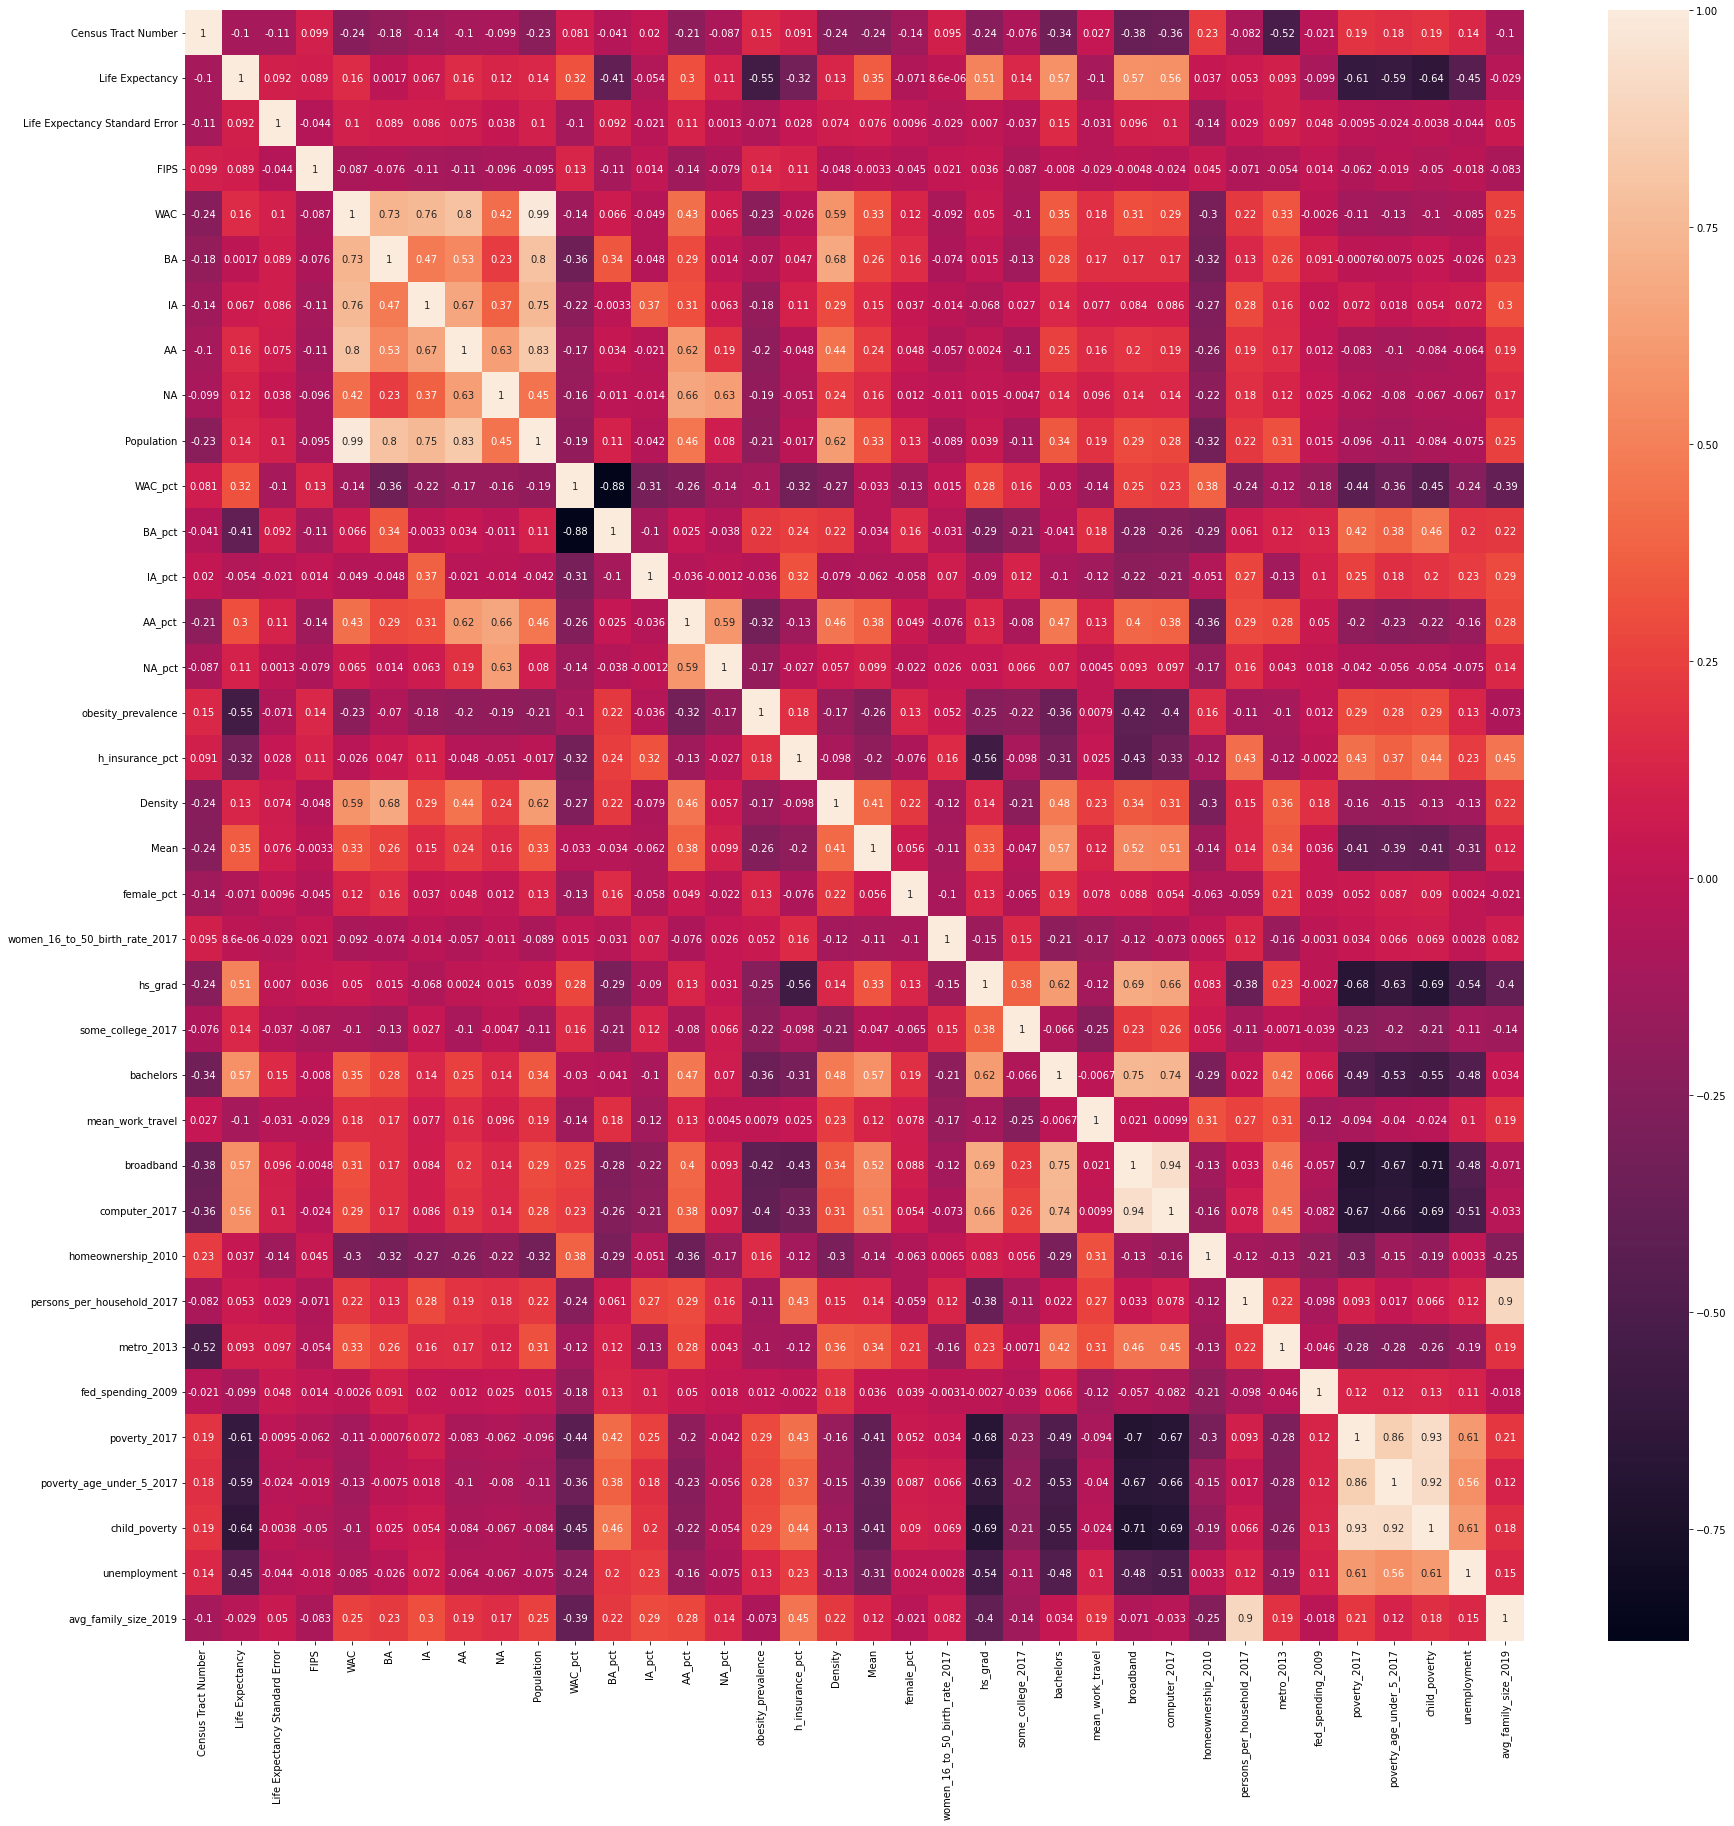

In [54]:
# Display heatmap to see the correlation between variables
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(), annot=True)

In [55]:
# Display pairplot to show relationship between variables
'''sns.pairplot(df[['WAC_pct', 'BA_pct', 'AA_pct', 'IA_pct', 'NA_pct', 'obesity_prevalence',
        'h_insurance_pct', 'Density', 'Mean','female_pct','hs_grad',
        'bachelors','child_poverty','broadband','unemployment','mean_work_travel','Life Expectancy']])'''

"sns.pairplot(df[['WAC_pct', 'BA_pct', 'AA_pct', 'IA_pct', 'NA_pct', 'obesity_prevalence',\n        'h_insurance_pct', 'Density', 'Mean','female_pct','hs_grad',\n        'bachelors','child_poverty','broadband','unemployment','mean_work_travel','Life Expectancy']])"

In [56]:
# Independent variables
X = df[['WAC_pct', 'BA_pct', 'AA_pct', 'IA_pct', 'NA_pct', 'obesity_prevalence',
        'h_insurance_pct', 'Density', 'Mean','female_pct','hs_grad',
        'bachelors','child_poverty','broadband','unemployment','mean_work_travel']]
# Dependent variable
y = df['Life Expectancy']

In [57]:
# Scale independent variables to be in a similar range
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [58]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Machine Learning Models

## Linear Regression

In [59]:
# Create linear regression model and fit training data
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

In [60]:
# Predict testing data
lr_pred = lr.predict(X_test)

In [61]:
# R-squared score
metrics.r2_score(y_test, lr_pred)

0.6010641164724544

In [62]:
# Mean absolute error
metrics.mean_absolute_error(y_test, lr_pred)

1.1499687635330187

In [63]:
# Bias
lr.intercept_

77.79018361668201

In [64]:
# Weights
lr.coef_

array([-3.85152709e+13, -3.53248084e+13, -8.69723476e+12, -1.59528155e+13,
       -1.68197187e+12, -8.00781250e-01, -9.76562500e-03, -1.66015625e-01,
       -1.97753906e-02, -5.37109375e-02, -3.90625000e-02,  7.78320312e-01,
       -7.42187500e-01, -2.59765625e-01, -2.09960938e-01, -1.73828125e-01])

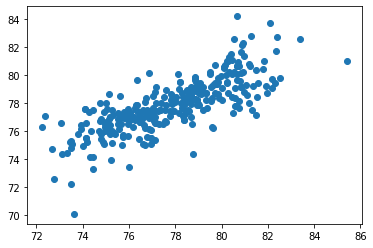

In [65]:
# Display actual data compared to prediction
plt.scatter(y_test, lr_pred)

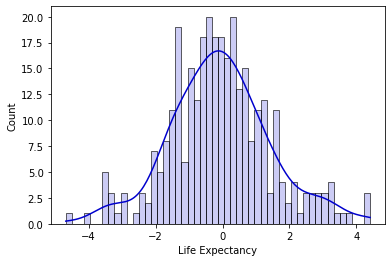

In [66]:
# Residual Error
sns.histplot((y_test - lr_pred), bins=50, kde=True, color='mediumblue', alpha=0.2)

## Random Forest Regression

In [67]:
# Create random forest regression model and fit training data
rfr = RandomForestRegressor(n_estimators=170)

rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=170)

In [68]:
# Predict testing data
rfr_pred = rfr.predict(X_test)

In [69]:
# R-squared score
metrics.r2_score(y_test, rfr_pred)

0.7794451813890843

In [70]:
# Mean absolute error
metrics.mean_absolute_error(y_test, rfr_pred)

0.7988625026283749

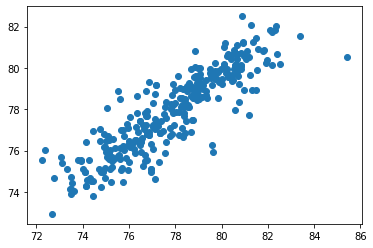

In [71]:
# Display actual data compared to prediction
plt.scatter(y_test, rfr_pred)

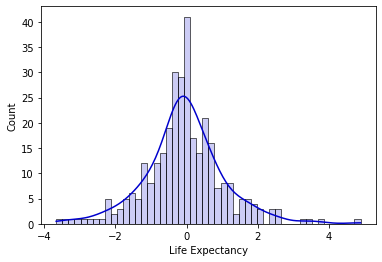

In [72]:
# Residual Error
sns.histplot((y_test - rfr_pred), bins=50, kde=True, color='mediumblue', alpha=0.2)

## Extra Trees Regression

In [73]:
# Create extra tress regression model and fit training data
etr = ExtraTreesRegressor(n_estimators=170)

etr.fit(X_train, y_train)

ExtraTreesRegressor(n_estimators=170)

In [74]:
# Predict testing data
etr_pred = etr.predict(X_test)

In [75]:
# R-squared score
metrics.r2_score(y_test, etr_pred)

0.7811924894542233

In [76]:
# Mean absolute error
metrics.mean_absolute_error(y_test, etr_pred)

0.7425874035745142

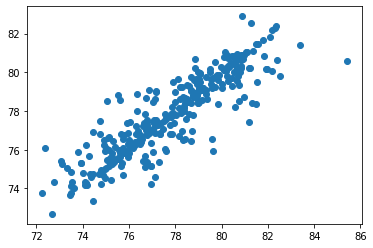

In [77]:
# Display actual data compared to prediction
plt.scatter(y_test, etr_pred)

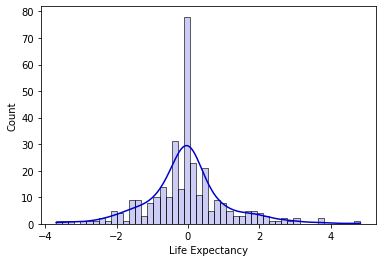

In [78]:
# Residual Error
sns.histplot((y_test - etr_pred), bins=50, kde=True, color='mediumblue', alpha=0.2)

## Gradient Boosting Regression

In [79]:
# Create boosting regression model and fit training data
boost = GradientBoostingRegressor(n_estimators=170)

boost.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=170)

In [80]:
# Predict testing data
boost_pred = boost.predict(X_test)

In [81]:
# R-squared score
metrics.r2_score(y_test, boost_pred)

0.7620675096545041

In [82]:
# Mean absolute error
metrics.mean_absolute_error(y_test, boost_pred)

0.8792010981963843

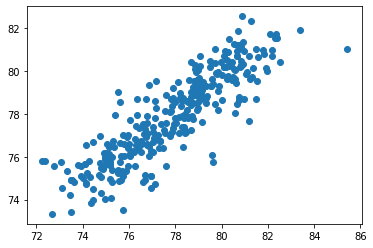

In [83]:
# Display actual data compared to prediction
plt.scatter(y_test, boost_pred)

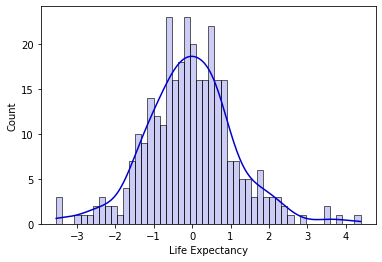

In [84]:
# Residual Error
sns.histplot((y_test - boost_pred), bins=50, kde=True, color='mediumblue', alpha=0.2)

## SVR Regression

In [85]:
# Create SVR model and fit training data
svr = SVR(kernel='rbf')

svr.fit(X_train, y_train)

SVR()

In [86]:
# Predict testing data
svr_pred = svr.predict(X_test)

In [87]:
# R-squared score
metrics.r2_score(y_test, svr_pred)

0.6953125882656261

In [88]:
# Mean absolute error
metrics.mean_absolute_error(y_test, svr_pred)

0.9598624739011602

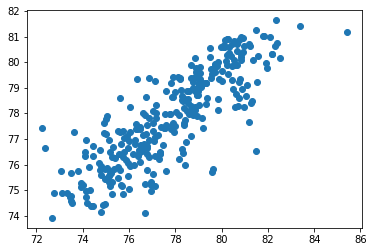

In [89]:
# Display actual data compared to prediction
plt.scatter(y_test, svr_pred)

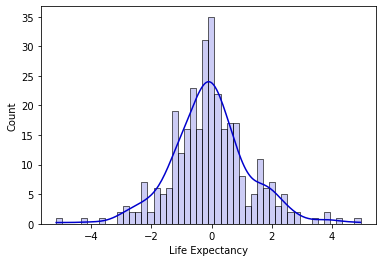

In [90]:
# Residual Error
sns.histplot((y_test - svr_pred), bins=50, kde=True, color='mediumblue', alpha=0.2)

# Neural Network

In [91]:
# Import neural network libraries
from keras import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

In [92]:
# Create neural network
model = Sequential()

# Input Layer
model.add(Dense(32, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))

# Hidden Layers
model.add(Dense(64, kernel_initializer='normal',activation='relu'))
model.add(Dense(128, kernel_initializer='normal',activation='relu'))
model.add(Dense(128, kernel_initializer='normal',activation='relu'))
model.add(Dense(128, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [93]:
# Fit training data to model
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split = 0.2)

Epoch 1/200
32/32 [==============================] - 3s 9ms/step - loss: 72.2038 - mean_absolute_error: 72.2038 - val_loss: 31.1628 - val_mean_absolute_error: 31.1628
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 16.5746 - mean_absolute_error: 16.5746 - val_loss: 8.7358 - val_mean_absolute_error: 8.7358
Epoch 3/200
32/32 [==============================] - 0s 4ms/step - loss: 6.8505 - mean_absolute_error: 6.8505 - val_loss: 4.7325 - val_mean_absolute_error: 4.7325
Epoch 4/200
32/32 [==============================] - 0s 4ms/step - loss: 4.1496 - mean_absolute_error: 4.1496 - val_loss: 3.9685 - val_mean_absolute_error: 3.9685
Epoch 5/200
32/32 [==============================] - 0s 4ms/step - loss: 3.1282 - mean_absolute_error: 3.1282 - val_loss: 2.5030 - val_mean_absolute_error: 2.5030
Epoch 6/200
32/32 [==============================] - 0s 4ms/step - loss: 2.3968 - mean_absolute_error: 2.3968 - val_loss: 1.6880 - val_mean_absolute_error: 1.6880
Epoch 7/200
32/3

In [94]:
# Predict testing data
nn_pred = model.predict(X_test)

In [95]:
# R-squared score
metrics.r2_score(y_test, nn_pred)

0.6173195078310211

In [96]:
# Mean absolute error
metrics.mean_absolute_error(y_test, nn_pred)

1.0799693011712905

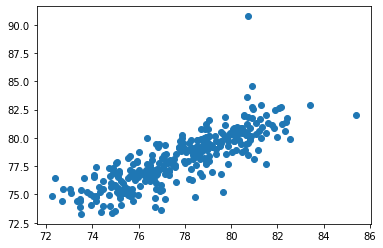

In [97]:
# Display actual data compared to prediction
plt.scatter(y_test, nn_pred)